In [1]:
import pandas as pd
import numpy as np
from skimpy import skim
from scipy import stats
from itertools import product
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score
%matplotlib inline

sns.set()
sns.set_style("whitegrid") 
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
socio = pd.read_excel('../../RA/Data/Future_production_demand_data/EAT_Lancet_release.xlsx', 
                      sheet_name='socio_data', 
                      usecols=['SSP', 'Item', 'Region', 'Year', 'Value'])

cons = pd.read_excel('../../RA/Data/Future_production_demand_data/EAT_Lancet_release.xlsx', 
                      sheet_name='cons_data', 
                     usecols=['kcal_scn', 'SSP_scn', 'measure', 'item', 'diet_scn', 'food_group', 'region', 'year', 'value'])

prod = pd.read_excel('../../RA/Data/Future_production_demand_data/EAT_Lancet_release.xlsx', 
                      sheet_name='prod_data', 
                     usecols=['kcal_scn', 'SSP_scn', 'measure', 'diet_scn', 'waste_scn', 'food_group', 'region', 'year', 'value'])

In [3]:
# time trends

In [4]:
# the numbers differ slightly across years - even in some non benchmark scenarios like maize for vgn and veg. 
# the differences are small though. this happens because of income changes in ssp2

# cons[(cons['kcal_scn']=='2100kcal') 
#     & (cons['measure']=='abs') 
#     & (cons['item']=='g/d_w')
#     & (cons['region']=='IND')].sort_values(by=['food_group', 'diet_scn', 'year'])

In [5]:
cons = cons[cons['measure']=='abs'].reset_index(drop=True)

In [6]:
# what is other cal? why is it negative sometimes? 

In [7]:
cons[cons['food_group']=='othrcal']['diet_scn'].value_counts()

diet_scn
BMK    972
Name: count, dtype: int64

In [8]:
cons[cons['value']<0].shape

(92, 9)

In [9]:
cons[cons['value']<0]['item'].value_counts()

item
kcal/d_w    92
Name: count, dtype: int64

In [10]:
cons[cons['value']<0]['food_group'].value_counts()

food_group
othrcal    92
Name: count, dtype: int64

In [11]:
cons[cons['value']<0]['diet_scn'].value_counts()

diet_scn
BMK    92
Name: count, dtype: int64

In [12]:
cons[cons['value']<0]['kcal_scn'].value_counts()

kcal_scn
2100kcal    46
2500kcal    46
Name: count, dtype: int64

In [13]:
cons[cons['value']<0]['year'].value_counts()

year
2050    32
2010    30
2030    30
Name: count, dtype: int64

In [14]:
cons[cons['value']<0]['region'].value_counts()

region
BGD    6
BTN    6
DZA    6
ERI    6
GNQ    6
KAZ    6
MDG    6
MMR    6
OIO    6
PNG    6
PSE    6
SEN    6
SLB    6
TJK    6
VNM    6
IRN    2
Name: count, dtype: int64

In [15]:
# 5 year timesteps, % increase in diet B

# 2010 - 100% BMK 
# 2015 - 100% BMK = 0.75*2010 BMK + 0.25*2030 BMK
# 2020 - 100% BMK = 0.5*2010 BMK + 0.5*2030 BMK
# 2025 - 500/6% BMK, 100/6% diet B = 0.5*2020 BMK calc + 0.5*2030 mix
# 2030 - 400/6% BMK, 200/6% diet B = 4/6*2030 BMK + 2/6*2030 diet B               
# 2035 - 50% BMK, 50% diet B = 0.75*2030 mix + 0.25*2050 diet B
# 2040 - 200/6% BMK, 400/6% diet B = 0.5*2030 mix + 0.5*2050 diet B
# 2045 - 100/6% BMK, 500/6% diet B = 0.25*2030 mix + 0.75*2050 diet B
# 2050 - 100 % diet B  

In [16]:
cons_cal = cons[cons['item']=='kcal/d_w']
cons_g = cons[cons['item']=='g/d_w']

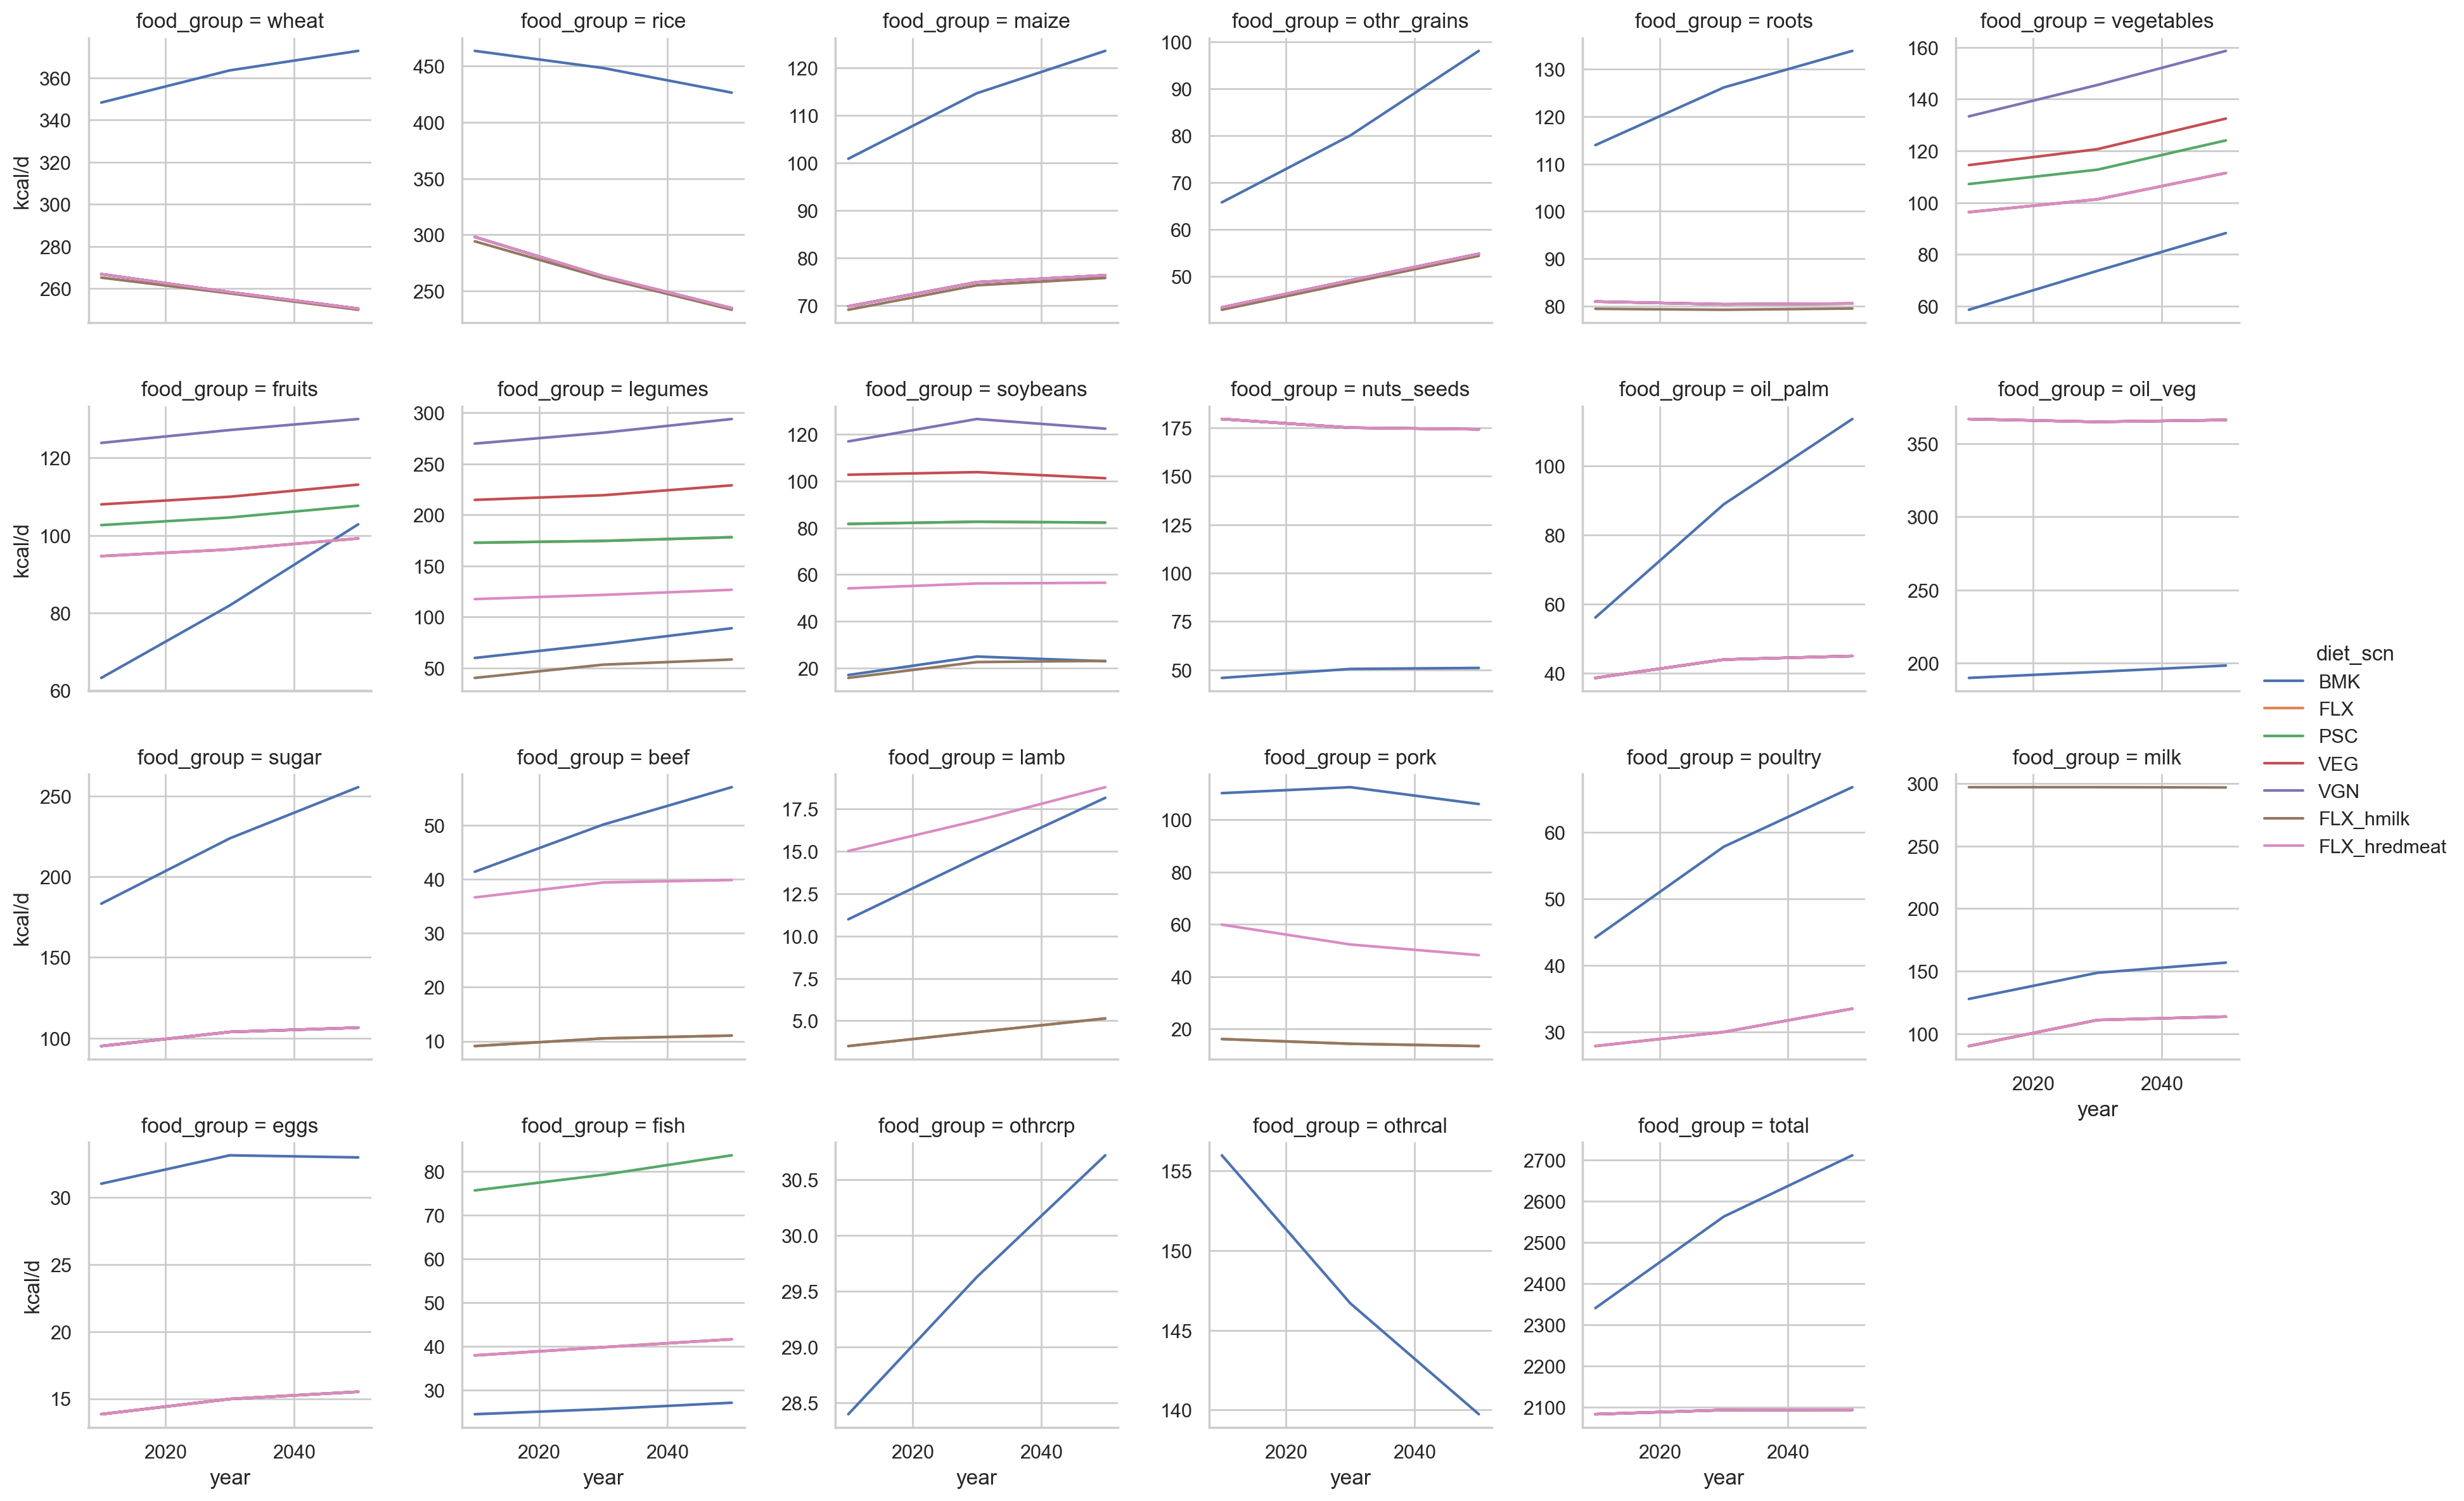

In [17]:
reg = 'all-r'
kcal = '2100kcal'

g = sns.relplot(
    data=cons_cal[(cons_cal['region']==reg) & (cons_cal['kcal_scn']==kcal)],
    x="year", y="value",
    hue="diet_scn", col="food_group",
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar',
               'beef', 'lamb', 'pork', 'poultry', 'milk', 'eggs', 'fish', 'othrcrp', 'othrcal', 'total'],
    col_wrap=6, 
    kind="line", 
    height=3, facet_kws=dict(sharey=False),
)
g.set_ylabels('kcal/d')

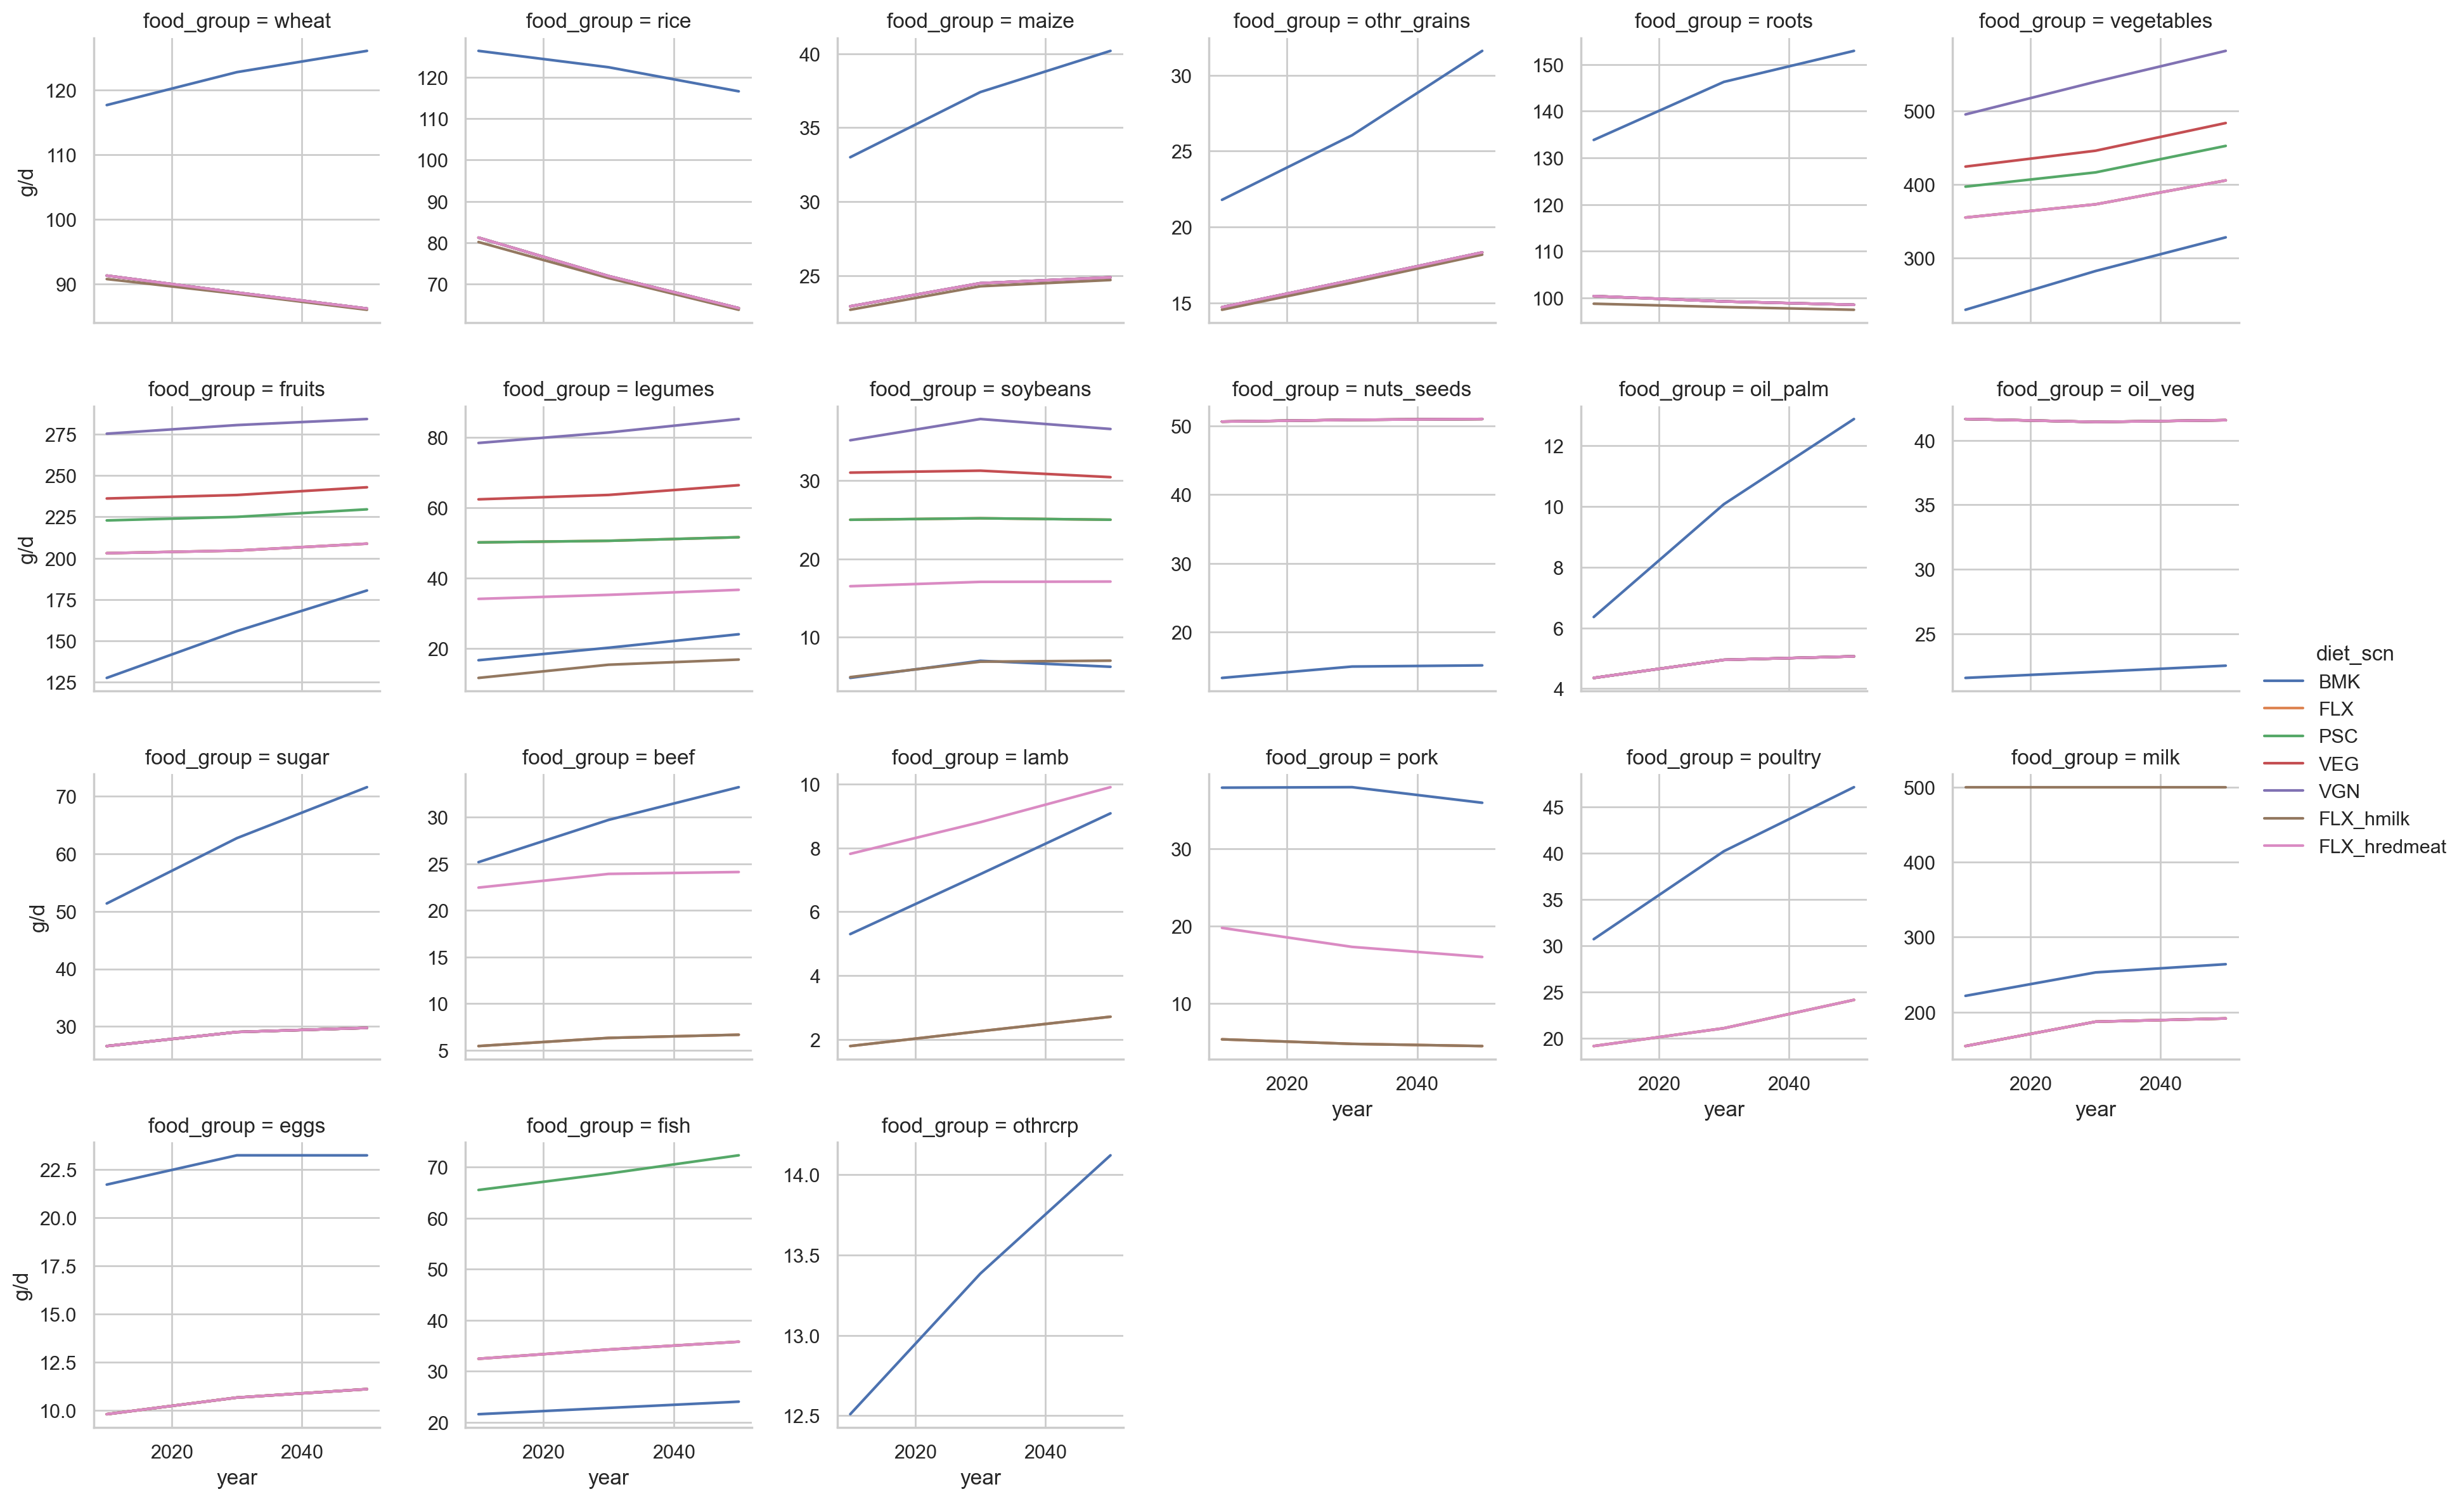

In [18]:
reg = 'all-r'
kcal = '2100kcal'

g = sns.relplot(
    data=cons_g[(cons_g['region']==reg) & (cons_g['kcal_scn']==kcal)],
    x="year", y="value",
    hue="diet_scn", col="food_group",
    col_wrap=6, 
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar',
               'beef', 'lamb', 'pork', 'poultry', 'milk', 'eggs', 'fish', 'othrcrp'],
    kind="line", 
    height=3, facet_kws=dict(sharey=False),
)
g.set_ylabels('g/d')

In [19]:
kcal_scn = cons['kcal_scn'].unique()
SSP_scn	= cons['SSP_scn'].unique()
measure	= cons['measure'].unique()
diet_scn = cons['diet_scn'].unique()
region = cons['region'].unique()
year = cons['year'].unique()

cons_cal_df = pd.DataFrame(list(product(kcal_scn, SSP_scn, measure, 
                                        cons_cal['item'].unique(), diet_scn,
                                        cons_cal['food_group'].unique(), region, year)), 
                           columns=['kcal_scn', 'SSP_scn', 'measure',
                                    'item', 'diet_scn', 'food_group', 'region', 'year'])

cons_g_df = pd.DataFrame(list(product(kcal_scn, SSP_scn, measure, 
                                        cons_g['item'].unique(), diet_scn,
                                        cons_g['food_group'].unique(), region, year)), 
                           columns=['kcal_scn', 'SSP_scn', 'measure',
                                    'item', 'diet_scn', 'food_group', 'region', 'year'])

In [20]:
cons_g = cons_g.merge(cons_g_df, how='outer')
cons_g = cons_g.fillna(0)

cons_cal = cons_cal.merge(cons_cal_df, how='outer')
cons_cal = cons_cal.fillna(0)

In [21]:
cons_cal = cons_cal.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                                 'item', 'food_group', 'region', 'year'], 
                          columns='diet_scn', values='value').reset_index()

cons_g = cons_g.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                             'item', 'food_group', 'region', 'year'], 
                      columns='diet_scn', values='value').reset_index()

# 2010 and 2030
for diet in diet_scn: 
    cons_cal.loc[cons_cal['year']==2010, diet] = cons_cal[cons_cal['year']==2010]['BMK']
    cons_g.loc[cons_g['year']==2010, diet] = cons_g[cons_g['year']==2010]['BMK'] 

    cons_cal.loc[cons_cal['year']==2030, diet] = (cons_cal[cons_cal['year']==2030]['BMK']*2 + cons_cal[cons_cal['year']==2030][diet]) / 3
    cons_g.loc[cons_g['year']==2030, diet] = (cons_g[cons_g['year']==2030]['BMK']*2 + cons_g[cons_g['year']==2030][diet]) / 3

cons_cal = pd.melt(cons_cal, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'year'], 
           value_vars=diet_scn, ignore_index=False)
cons_g = pd.melt(cons_g, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'year'], 
         value_vars=diet_scn, ignore_index=False)

In [22]:
cons_cal = cons_cal.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                                 'item', 'food_group', 'region', 'diet_scn'], 
                          columns='year', values='value').reset_index()

cons_g = cons_g.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                             'item', 'food_group', 'region', 'diet_scn'], 
                      columns='year', values='value').reset_index()

# 2015 and 2020 temp - will be replaced with BMK calculation for all scenaios in next step
# 2025 will be calculated after that
# 2035, 2040, 2045 final
cons_cal[2015] = 0.75*cons_cal[2010] + 0.25*cons_cal[2030] # only temp
cons_cal[2020] = 0.5*cons_cal[2010] + 0.5*cons_cal[2030] # only temp
cons_cal[2035] = 0.75*cons_cal[2030] + 0.25*cons_cal[2050]
cons_cal[2040] = 0.5*cons_cal[2030] + 0.5*cons_cal[2050]
cons_cal[2045] = 0.25*cons_cal[2030] + 0.75*cons_cal[2050]

cons_g[2015] = 0.75*cons_g[2010] + 0.25*cons_g[2030] # only temp
cons_g[2020] = 0.5*cons_g[2010] + 0.5*cons_g[2030] # only temp
cons_g[2035] = 0.75*cons_g[2030] + 0.25*cons_g[2050]
cons_g[2040] = 0.5*cons_g[2030] + 0.5*cons_g[2050]
cons_g[2045] = 0.25*cons_g[2030] + 0.75*cons_g[2050]

cons_cal = pd.melt(cons_cal, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'diet_scn'], 
           value_vars=[2010, 2015, 2020, 2030, 2035, 2040, 2045, 2050], ignore_index=False)
cons_g = pd.melt(cons_g, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'diet_scn'], 
         value_vars=[2010, 2015, 2020, 2030, 2035, 2040, 2045, 2050], ignore_index=False)

In [23]:
cons_cal = cons_cal.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                                 'item', 'food_group', 'region', 'year'], 
                          columns='diet_scn', values='value').reset_index()

cons_g = cons_g.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                             'item', 'food_group', 'region', 'year'], 
                      columns='diet_scn', values='value').reset_index()

# 2015 and 2020
for diet in diet_scn: 
    cons_cal.loc[cons_cal['year']==2015, diet] = cons_cal[cons_cal['year']==2015]['BMK']
    cons_g.loc[cons_g['year']==2015, diet] = cons_g[cons_g['year']==2015]['BMK'] 
    
    cons_cal.loc[cons_cal['year']==2020, diet] = cons_cal[cons_cal['year']==2020]['BMK']
    cons_g.loc[cons_g['year']==2020, diet] = cons_g[cons_g['year']==2020]['BMK']   

cons_cal = pd.melt(cons_cal, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'year'], 
           value_vars=diet_scn, ignore_index=False)
cons_g = pd.melt(cons_g, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'year'], 
         value_vars=diet_scn, ignore_index=False)

In [24]:
cons_cal = cons_cal.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                                 'item', 'food_group', 'region', 'diet_scn'], 
                          columns='year', values='value').reset_index()

cons_g = cons_g.pivot(index=['kcal_scn', 'SSP_scn', 'measure',
                             'item', 'food_group', 'region', 'diet_scn'], 
                      columns='year', values='value').reset_index()

# 2025
cons_cal[2025] = 0.5*cons_cal[2020] + 0.5*cons_cal[2030]
cons_g[2025] = 0.5*cons_g[2020] + 0.5*cons_g[2030]

cons_cal = pd.melt(cons_cal, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'diet_scn'], 
           value_vars=[2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050], ignore_index=False)
cons_g = pd.melt(cons_g, id_vars=['kcal_scn', 'SSP_scn', 'measure', 'item', 'food_group', 'region', 'diet_scn'], 
         value_vars=[2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050], ignore_index=False)

In [25]:
cons_g_sc = cons_g.merge(cons_g[cons_g['diet_scn']=='BMK'].drop('diet_scn', axis=1).rename(columns={'value': 'value_BMK'}))
cons_g_sc['value'] = cons_g_sc['value'] / cons_g_sc['value_BMK']
cons_g_sc = cons_g_sc.drop('value_BMK', axis=1)
cons_g_sc['measure'] = 'rel'

cons_cal_sc = cons_cal.merge(cons_cal[cons_cal['diet_scn']=='BMK'].drop('diet_scn', axis=1).rename(columns={'value': 'value_BMK'}))
cons_cal_sc['value'] = cons_cal_sc['value'] / cons_cal_sc['value_BMK']
cons_cal_sc = cons_cal_sc.drop('value_BMK', axis=1)
cons_cal_sc['measure'] = 'rel'

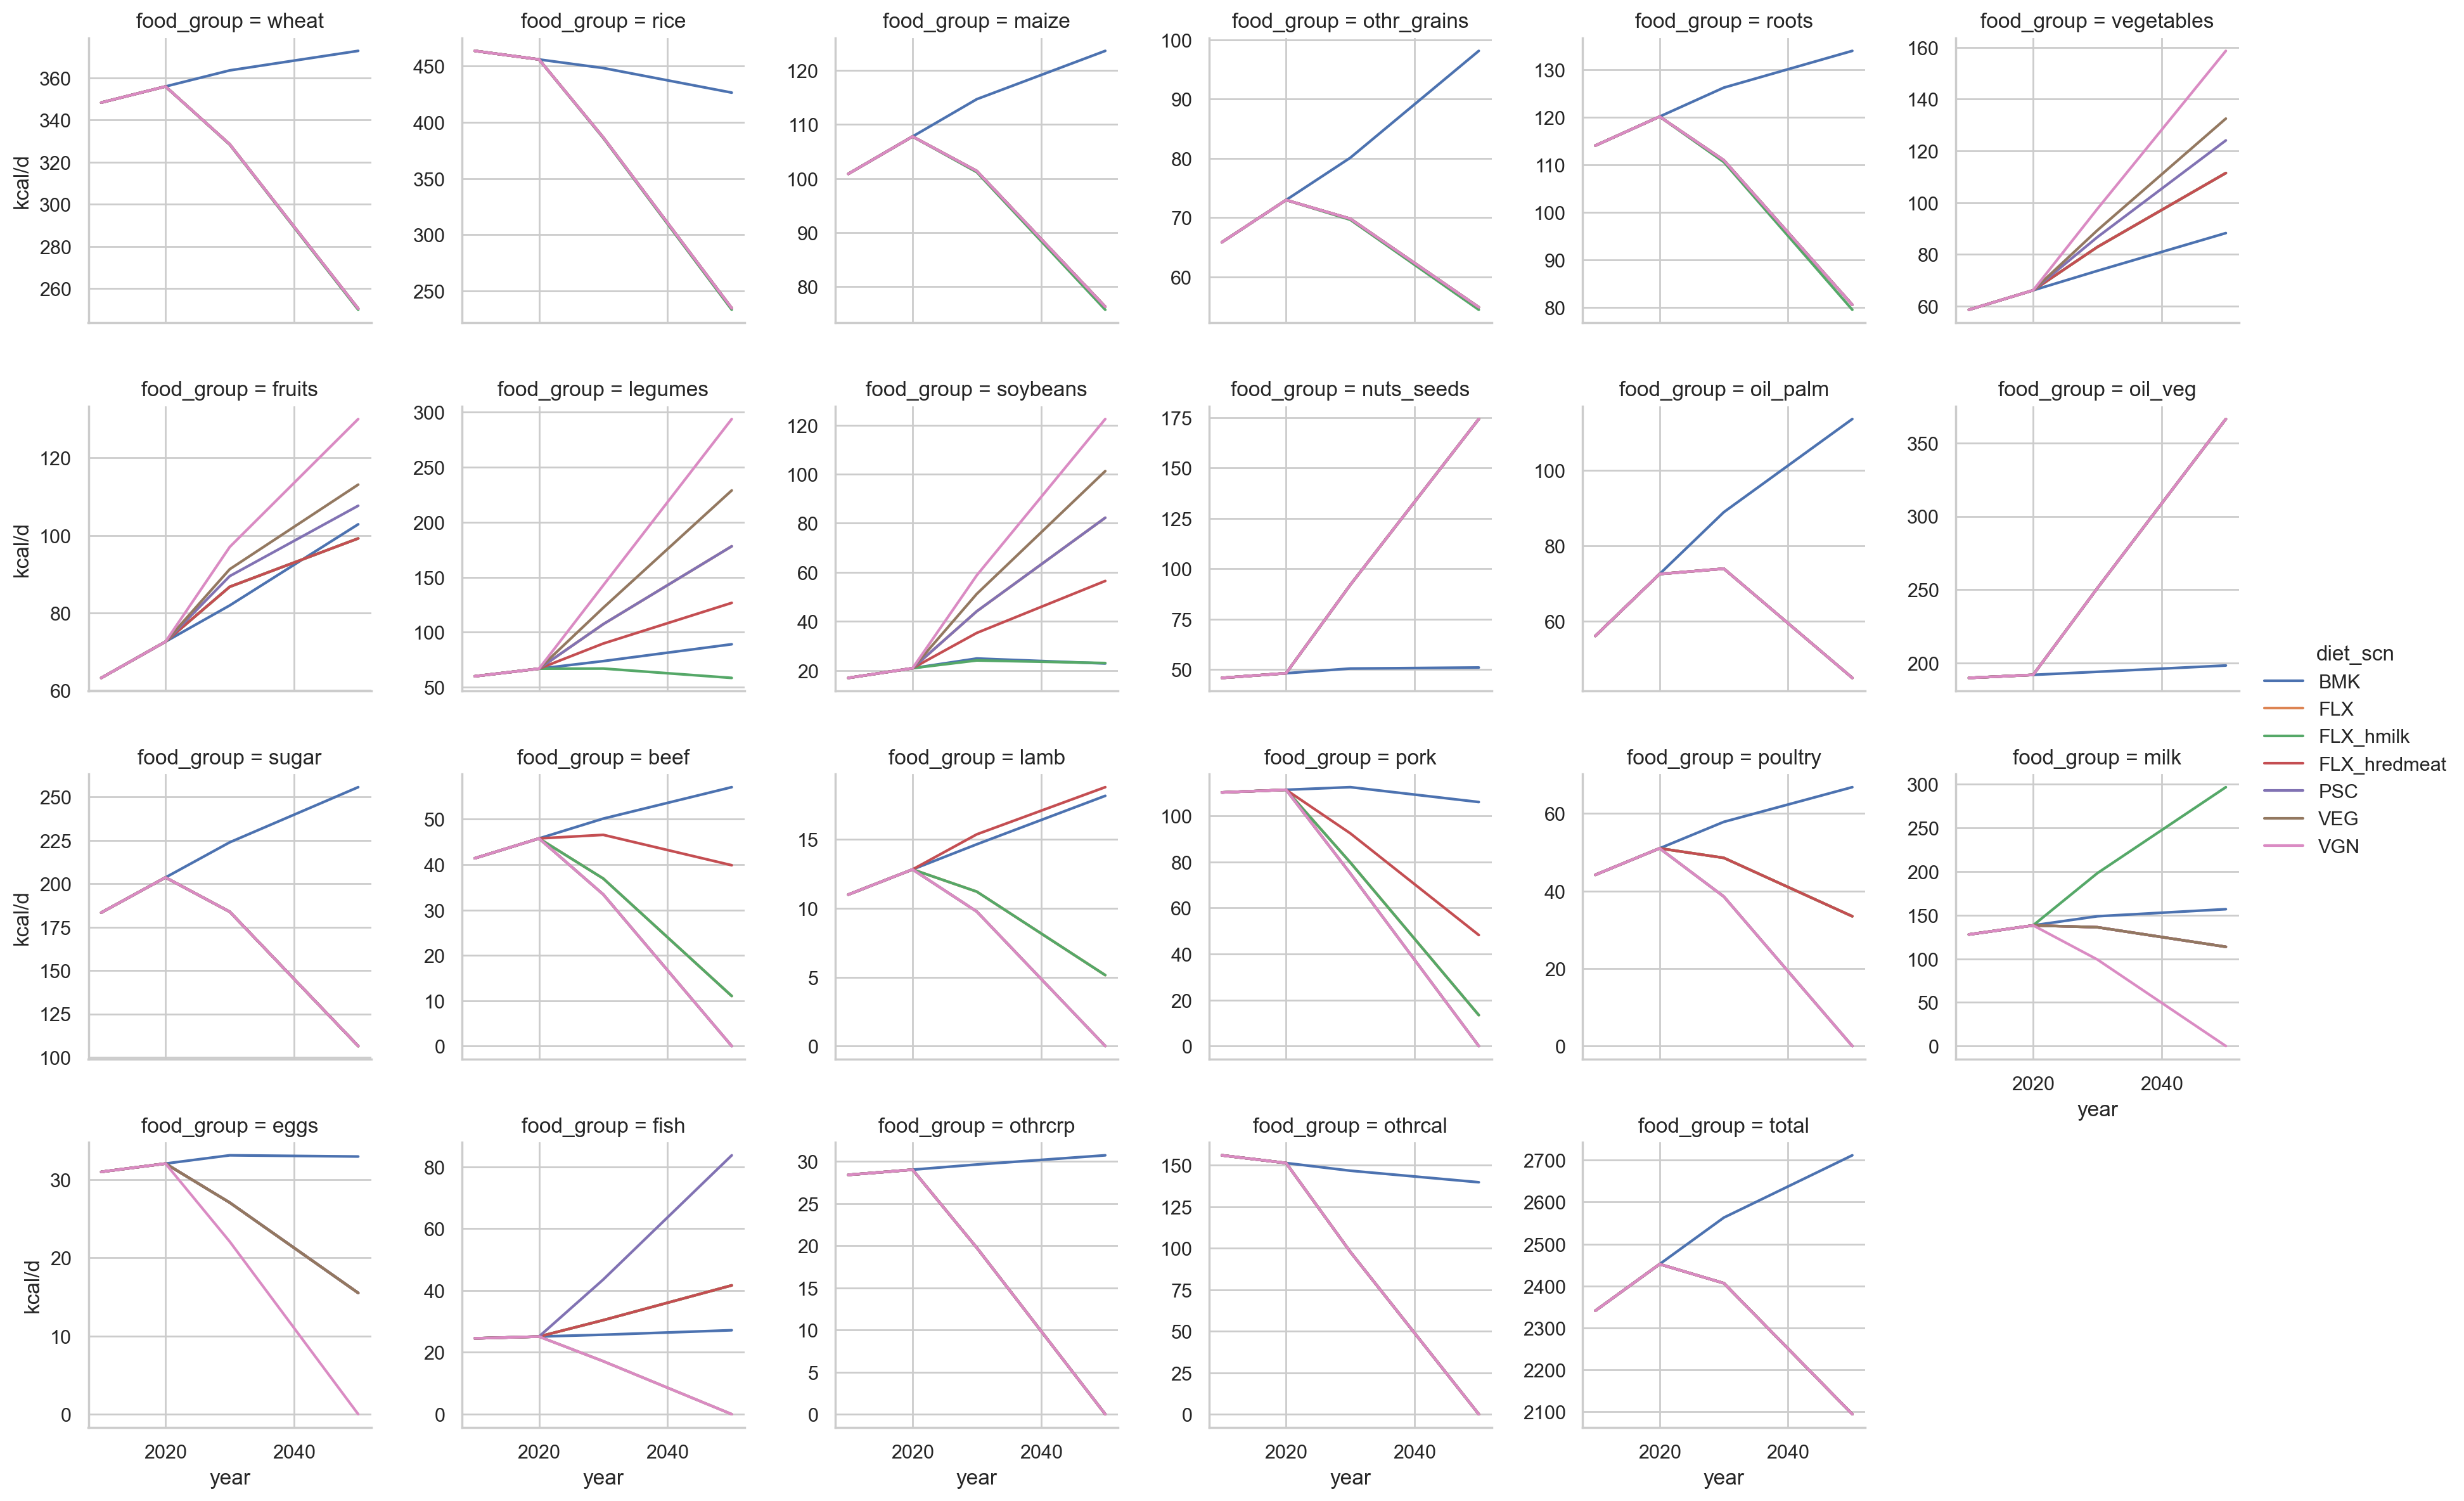

In [26]:
reg = 'all-r'
kcal = '2100kcal'

g = sns.relplot(
    data=cons_cal[(cons_cal['region']==reg) & (cons_cal['kcal_scn']==kcal)],
    x="year", y="value",
    hue="diet_scn", col="food_group",
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar',
               'beef', 'lamb', 'pork', 'poultry', 'milk', 'eggs', 'fish', 'othrcrp', 'othrcal', 'total'],
    col_wrap=6, 
    kind="line", 
    height=3, facet_kws=dict(sharey=False),
)
g.set_ylabels('kcal/d')

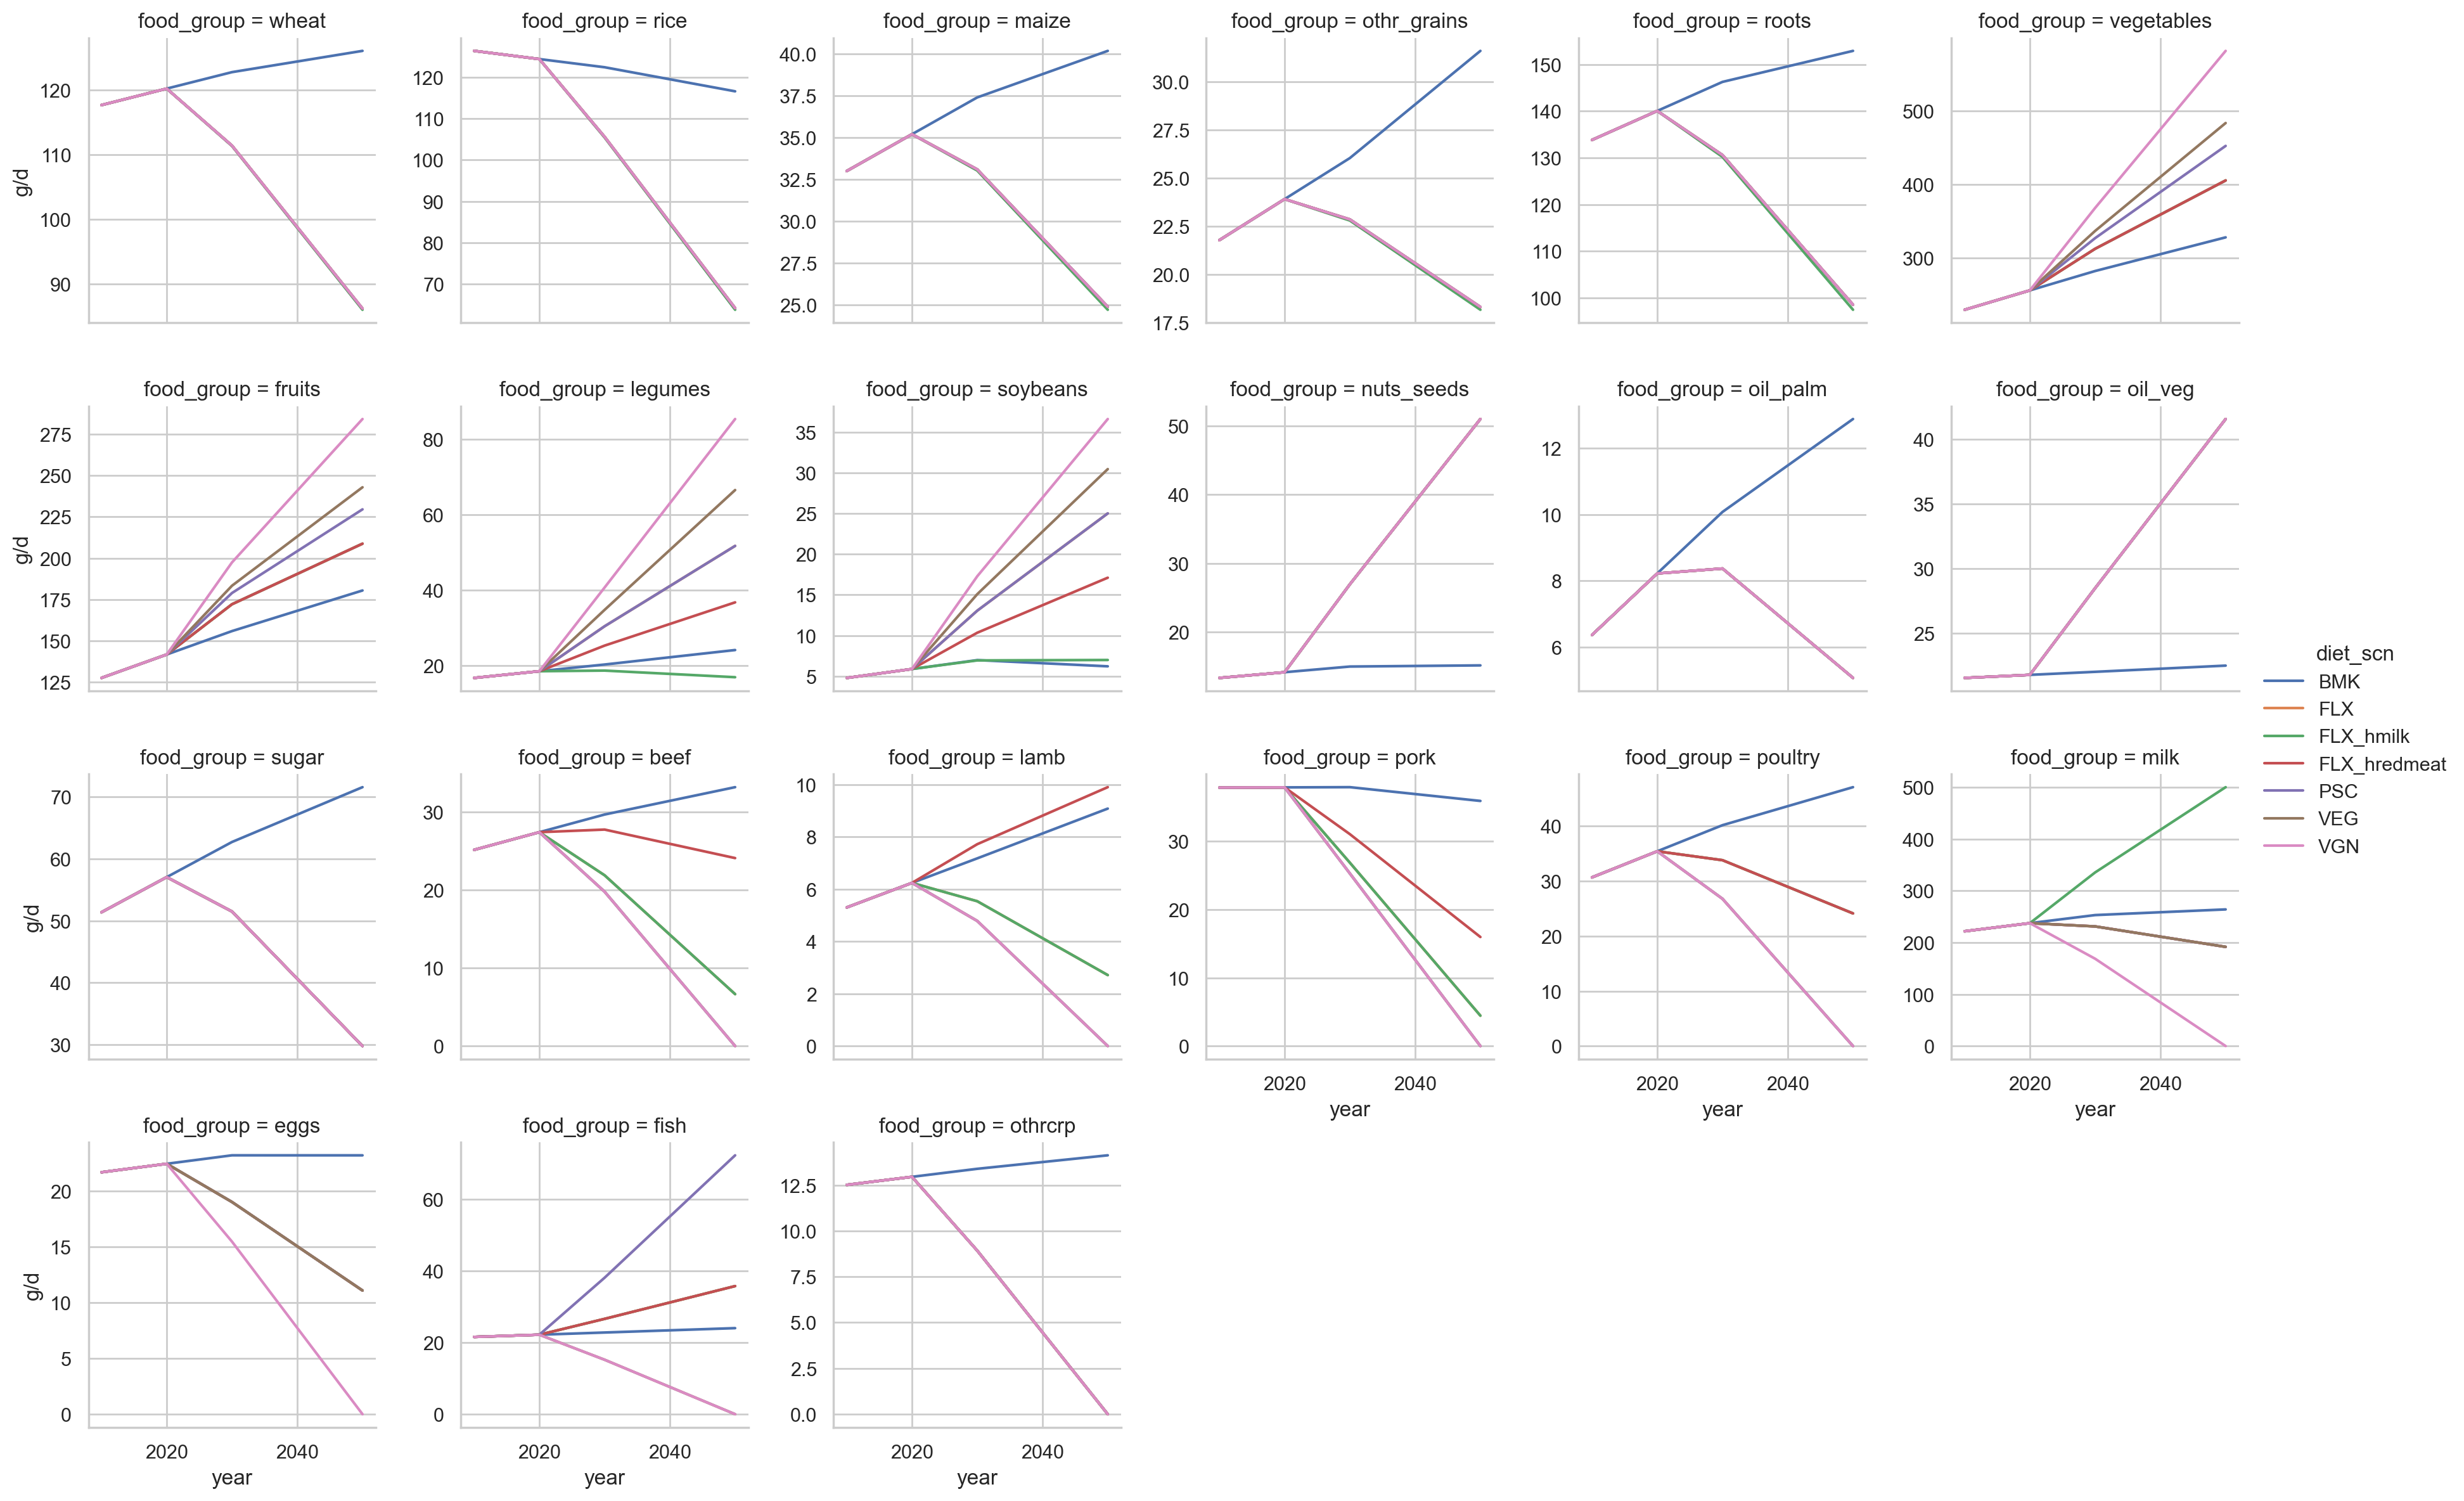

In [27]:
reg = 'all-r'
kcal = '2100kcal'

g = sns.relplot(
    data=cons_g[(cons_g['region']==reg) & (cons_g['kcal_scn']==kcal)],
    x="year", y="value",
    hue="diet_scn", col="food_group",
    col_wrap=6, 
    col_order=['wheat', 'rice', 'maize', 'othr_grains', 'roots', 'vegetables', 'fruits', 
               'legumes', 'soybeans', 'nuts_seeds', 'oil_palm', 'oil_veg', 'sugar',
               'beef', 'lamb', 'pork', 'poultry', 'milk', 'eggs', 'fish', 'othrcrp'],
    kind="line", 
    height=3, facet_kws=dict(sharey=False),
)
g.set_ylabels('g/d')

In [52]:
cons = pd.concat([cons_g, cons_g_sc, cons_cal, cons_cal_sc], ignore_index=True)

In [56]:
cons.to_csv('../../RA/Data/Future_production_demand_data/demand_scn.csv', index=False)

In [3]:
crop_conversion = pd.read_csv('../../RA/Data/Crop_conversion/crop_correspondance_tables_output.csv')

In [4]:
crop_conversion.head()

,IMPACT_code,IMPACT_name,FAO_name,FAO_code,SPAM_code,SPAM_name,FABLE_code,Yield_data,Group
0,jbana,Bananas,Bananas,2615.0,BANA,Bananas,NaN,NaN,Tropical fruit
1,jbarl,Barley,Barley,2513.0,BARL,Barley,barley,yes,Cereal
2,jbean,Beans,Beans,2546.0,BEAN,Beans,NaN,NaN,Legume
3,jcafe,Coffee,Coffee,2630.0,ACOF,Arabica Coffee,NaN,NaN,NaN
4,jcafe,Coffee,Coffee,2630.0,RCOF,Robusta Coffee,NaN,NaN,NaN


In [9]:
crop_conversion[['IMPACT_code', 'IMPACT_name', 'SPAM_name']].drop_duplicates()

,IMPACT_code,IMPACT_name,SPAM_name
0,jbana,Bananas,Bananas
1,jbarl,Barley,Barley
2,jbean,Beans,Beans
3,jcafe,Coffee,Arabica Coffee
4,jcafe,Coffee,Robusta Coffee
5,jcass,Cassava,Cassava
6,jchkp,Chickpeasb,Chickpeas
7,jcoco,Cocoa,Cocoa
8,jcott,Cottonc,Cotton
9,jcowp,Cowpeasb,Cowpeas


In [28]:
# food groups to IMPACT food names

# 'maize' - 'Maize'
# 'rice' - 'Ricee'
# 'wheat' - 'Wheat'
# 'othr_grains' - 'Sorghum', 'Millet', 'Barley', 'OtherCereals' 
# 'soybeans' - 'Soybeans'
# 'fruits' - 'Bananas', 'Plantains', '(Sub)-TropicalFruits', 'TemperateFruits' 
# 'vegetables' - 'Vegetables'
# 'roots' - 'Potatoes', 'SweetPotatoes', 'Cassava', 'Yams', 'SugarBeets' (?), 'OtherRoots&Tubers'
# 'legumes' - 'Beans', 'Chickpeasb', 'Cowpeasb', 'Lentilsa', 'PigeonPeasa', 'OtherPulsesa',
# 'nuts_seeds' - 'Groundnutd'
# 'oil_palm' - 'jpalm' [IMPACT_code]
# 'oil_veg' - 'Rapeseed', 'Sunflower', 'TotalOtherOilseeds'
# 'sugar' - 'Sugarcane'
# 'othrcrp' - 'Tea', 'Coffee', 'Cocoa', 'Other'
# 'beef' - NA
# 'pork' - NA 
# 'poultry' - NA 
# 'lamb' - NA
# 'fish' - NA
# 'eggs' - NA
# 'milk' - NA
# NA - 'Cottonc' (?) 

In [57]:
cons['food_group'].unique()

array(['beef', 'eggs', 'fish', 'fruits', 'lamb', 'legumes', 'maize',
       'milk', 'nuts_seeds', 'oil_palm', 'oil_veg', 'othr_grains',
       'othrcrp', 'pork', 'poultry', 'rice', 'roots', 'soybeans', 'sugar',
       'vegetables', 'wheat', 'othrcal', 'total'], dtype=object)